<a href="https://colab.research.google.com/github/Noramon22/Local-Repository/blob/main/portfolio_02_%E0%B8%84%E0%B8%AD%E0%B8%A3%E0%B9%8C%E0%B8%AA%E0%B8%9F%E0%B8%A3%E0%B8%B5Bigdata_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

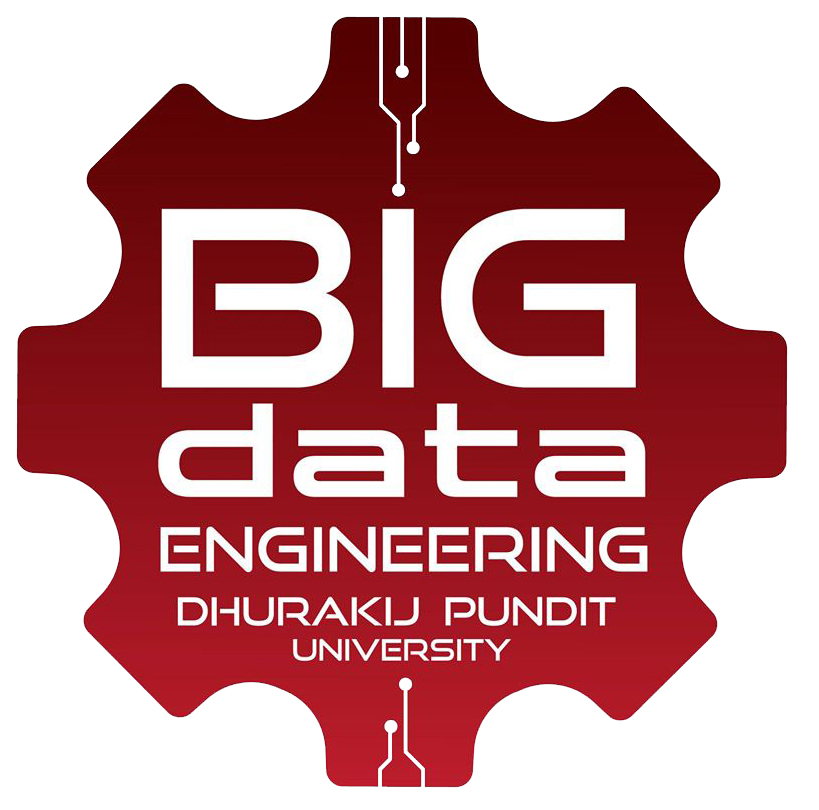

# Black-Ltterman

## Big Data Engineering - BD, CITE, DPU

Tanapat Kamsaiin 
BD'60

In [ ]:
!pip install yfinance
!pip install PyPortfolioOpt

     |████████████████████████████████| 6.3MB 35.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=23bdf1304ad3236761ffcbf15ce1818caa25a0f7f84bdfa6c3bd26b9c09175f1
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 1.3MB 28.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736103 sha256=42131738e43522e17fd4c8eca40a27c0f7e4585820261c9aef4b474f9cbfb3c9
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [ ]:
assets = ["MSFT", "AMZN", "BAC", "KO", "SBUX"]

In [ ]:
data = yf.download(assets, start='2015-01-03', end='2021-06-16')
data = data["Adj Close"]
data.tail()

[*********************100%***********************]  5 of 5 completed


,AMZN,BAC,KO,MSFT,SBUX
Date,,,,,
2021-06-09,3281.149902,42.320000,55.065083,253.589996,111.389999
2021-06-10,3349.649902,41.689999,55.491867,257.239990,112.209999
2021-06-11,3346.830078,41.860001,55.739998,257.890015,112.559998
2021-06-14,3383.870117,41.360001,55.549999,259.890015,112.449997
2021-06-15,3383.129883,41.389999,55.410000,258.359985,111.889999


In [ ]:
market_prices = yf.download("SPY", start='2015-01-03', end='2021-06-16')["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
2015-01-05    178.860443
2015-01-06    177.175781
2015-01-07    179.383591
2015-01-08    182.566742
2015-01-09    181.103745
Name: Adj Close, dtype: float64

In [ ]:
mcaps = {}
for t in assets:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AMZN': 1758527356928,
 'BAC': 332318212096,
 'KO': 231839039488,
 'MSFT': 1953915207680,
 'SBUX': 129259511808}

## Constructing the prior

In [ ]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [ ]:
S = risk_models.CovarianceShrinkage(data).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

4.012004036523663

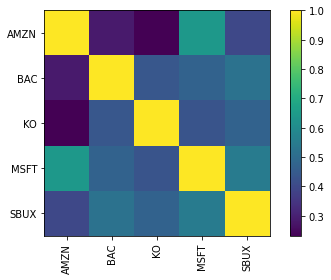

In [ ]:
plotting.plot_covariance(S, plot_correlation=True)

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.279563
BAC     0.185912
KO      0.101141
MSFT    0.263145
SBUX    0.168548
dtype: float64

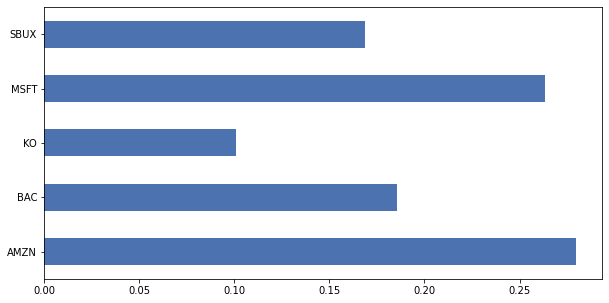

In [ ]:
market_prior.plot.barh(figsize=(10,5))

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [ ]:
# assets["MSFT", "AMZN", "BAC", "KO", "SBUX"]
# Absolute view

viewdict = {
    "MSFT": 0.10,
    "AMZN": 0.30,
    "BAC": 0.05,
    "KO": 0.05,
    "SBUX": 0.20,
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [ ]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7
]

In [ ]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

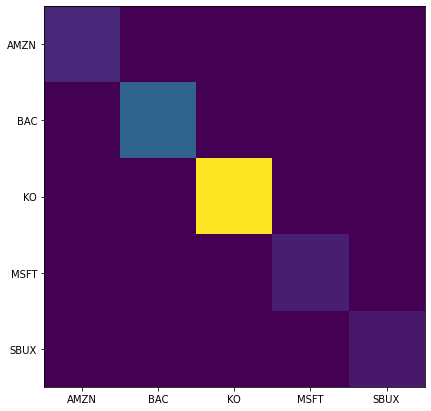

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

Note how KO, which we gave the lowest confidence, also has the highest uncertainty.

In [ ]:
np.diag(bl.omega)

array([0.00252284, 0.00696378, 0.021647  , 0.0018487 , 0.00147849])

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [ ]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25)
]

In [ ]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [ ]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.257172
BAC     0.144142
KO      0.073760
MSFT    0.227534
SBUX    0.165012
dtype: float64

Visualise how this compares to the prior and our views:

In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Market weight", "BL Portfolio", "Views"]).T
rets_df

,Market weight,BL Portfolio,Views
AMZN,0.279434,0.257172,0.30
BAC,0.185825,0.144142,0.05
KO,0.101178,0.073760,0.05
MSFT,0.263205,0.227534,0.10
SBUX,0.168546,0.165012,0.20


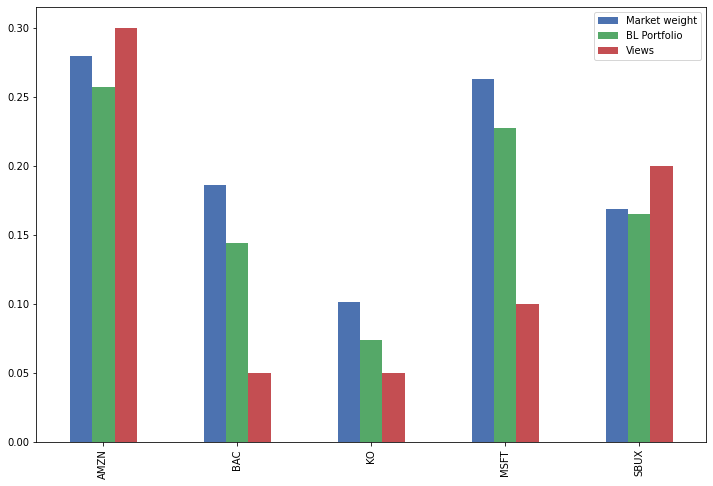

In [ ]:
rets_df.plot.bar(figsize=(12,8))

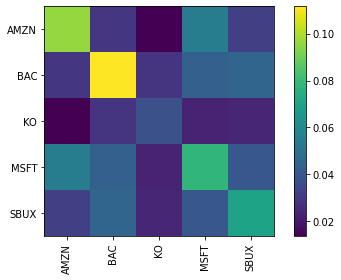

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl)

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes.

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:253: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AMZN', 0.32137),
             ('BAC', 0.14977),
             ('KO', 0.06382),
             ('MSFT', 0.27658),
             ('SBUX', 0.18846)])

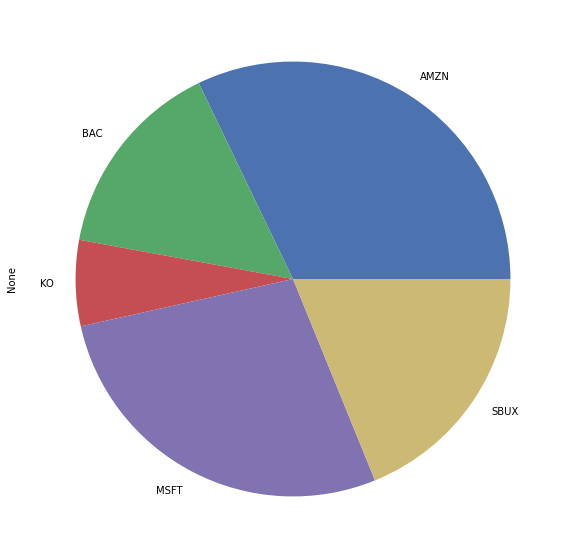

In [ ]:
pd.Series(weights).plot.pie(figsize=(10,10))